In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('HPa', 6, 2)

In [4]:
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            REPLAY_COVARIATES)

In [11]:
from src.analysis import detect_epoch_ripples
from src.data_processing import make_neuron_dataframe

ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, SAMPLING_FREQUENCY)
neuron_info = make_neuron_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False).query('numspikes > 0')

/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
INFO:src.analysis:Detecting ripples


In [22]:
from src.data_processing import get_spike_indicator_dataframe, reshape_to_segments

window_offset = (-0.100, 0.100)

ripple_locked_spikes = []

for neuron_key in neuron_info.index:
    spikes = get_spike_indicator_dataframe(neuron_key, ANIMALS)
    ripple_locked_spikes.append(
        reshape_to_segments(
            spikes, ripple_times, sampling_frequency=SAMPLING_FREQUENCY,
            window_offset=window_offset, segment_name='ripple_number'
        ).unstack(level=0))


In [27]:
from src.spectral import Multitaper, Connectivity
from src.parameters import MULTITAPER_PARAMETERS

m = Multitaper(
    np.stack(ripple_locked_spikes, axis=-1),
    **MULTITAPER_PARAMETERS['10Hz_Resolution'])
m.frequency_resolution

10.0

In [28]:
c = Connectivity.from_multitaper(m)

INFO:src.spectral.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.1, time_window_step=0.1, detrend_type='constant', start_time=0, n_tapers=1)


In [168]:
coherency = c.coherency()
frequency = c.frequencies
time = c.time

In [32]:
coherency.shape

(2, 75, 24, 24)

In [33]:
power = c.power()
power.shape

(2, 75, 24)

In [289]:
from src.spectral.statistics import coherence_rate_adjustment

adjustment = []

for spikes, before_ripple_power in zip(ripple_locked_spikes, power[0, :, :].T):
    before_ripple_average_firing_rate = np.mean(spikes.loc[:0].values) * SAMPLING_FREQUENCY
    after_ripple_average_firing_rate = np.mean(spikes.loc[0:].values) * SAMPLING_FREQUENCY
    adjustment.append(
        coherence_rate_adjustment(
            before_ripple_average_firing_rate,
            after_ripple_average_firing_rate, before_ripple_power, dt=1/SAMPLING_FREQUENCY))

In [290]:
adjustment = np.stack(adjustment, axis=-1)
adjustment.shape

(75, 24)

In [171]:
coherency[0, ...] = adjustment[..., np.newaxis] * adjustment[..., np.newaxis, :] * coherency[0, ...]

In [172]:
coherence_difference = np.diff(np.abs(coherency) ** 2, axis=0).squeeze()

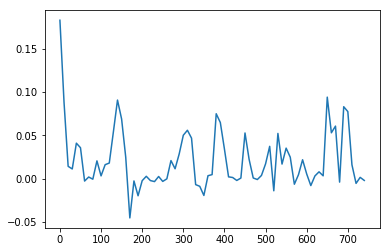

In [173]:
plt.plot(frequency, coherence_difference[:, 1, 5]);

In [175]:
from src.spectral.statistics import fisher_z_transform, coherence_bias

n_ripples = len(ripple_times)
bias = coherence_bias(n_ripples * m.n_tapers)
coherence_z_difference = fisher_z_transform(coherency[1, ...], bias, coherency[0, ...], bias)

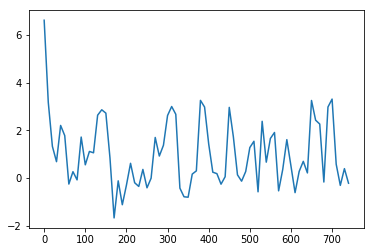

In [176]:
plt.plot(frequency, coherence_z_difference[:, 1, 5]);

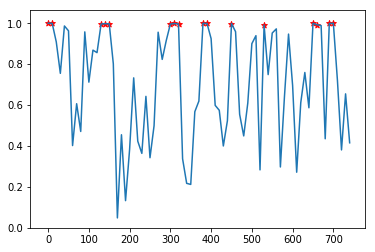

In [178]:
from src.spectral.statistics import get_normal_distribution_p_values, adjust_for_multiple_comparisons

p_values = get_normal_distribution_p_values(coherence_z_difference[:, 1, 5])
is_sig = adjust_for_multiple_comparisons(
    get_normal_distribution_p_values(coherence_z_difference[:, 1, 5]))

plt.plot(frequency, 1 - p_values);
plt.scatter(frequency[is_sig], 1 - p_values[is_sig], color='red', marker='*');